In [2]:
import math
import pandas as pd
import numpy as np
from plotnine import *
import warnings
import datetime
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import pitch-by-pitch data from the 2017-2021 seasons
df_reg = pd.read_csv('regular_szn_data.csv')
df_post = pd.read_csv('post_szn_data.csv')

# Concatenate
df = pd.concat([df_reg,df_post], ignore_index = True, axis = 0)

# Remove index column
df = df.drop('index', axis = 1)

In [4]:
# Print df shape for number of pitches

print("We have ", shape(df)[0]," pitches")

We have  3329028  pitches


In [5]:
# Limit df to just rows with an event
df = df[df.events.notnull()]

print("We now have ", shape(df)[0], " events")

We now have  848148  events


In [6]:
# Remove events that involve just base runners

base_runner_events = ['caught_stealing_3b',
                     'caught_stealing_2b',
                     'pickoff_2b','pickoff_1b',
                     'stolen_base_2b','caught_stealing_home',
                     'wild_pitch','pickoff_caught_stealing_3b',
                     'pickoff_caught_stealing_2b','pickoff_caught_stealing_home',
                     'stolen_base_home','passed_ball','pickoff_3b','game_advisory']

df = df[~df.events.isin(base_runner_events)]

print("We now have ", shape(df)[0], " events")

We now have  847075  events


In [7]:
# Remove any duplicates

# How many duplicates are there
print("There are ", len(df)-len(df.drop_duplicates()), "duplicates")

# Remove from all datasets
df_reg = df_reg.drop_duplicates()
df_post = df_post.drop_duplicates()

df = df.drop_duplicates()

There are  31713 duplicates


In [8]:
# Determine the base setting function
# 000 = no runners on
# 100 = runner on first
# 020 = runner on second
# 003 = runner on third
# 120 = runners on first and second
# 103 = runners on first and third
# 023 = runners on second and third
# 123 = bases loaded

def base_setting(first, second, third):
    if (math.isnan(first) == True and math.isnan(second) == True and math.isnan(third) == True):
        return("000")
    elif (math.isnan(first) == False and math.isnan(second) == True and math.isnan(third) == True):
        return("100")
    elif (math.isnan(first) == True and math.isnan(second) == False and math.isnan(third) == True):
        return("020")
    elif (math.isnan(first) == True and math.isnan(second) == True and math.isnan(third) == False):
        return("003")
    elif (math.isnan(first) == False and math.isnan(second) == False and math.isnan(third) == True):
        return("120")
    elif (math.isnan(first) == False and math.isnan(second) == True and math.isnan(third) == False):
        return("103")
    elif (math.isnan(first) == True and math.isnan(second) == False and math.isnan(third) == False):
        return("023")
    elif (math.isnan(first) == False and math.isnan(second) == False and math.isnan(third) == False):
        return("123")
    else:
        return("hi")

In [9]:
# Generate base settng

df['base_set'] = df.apply(lambda row: base_setting(row.on_1b, row.on_2b, row.on_3b), axis = 1)

In [10]:
# Generate RBI calculation function
# If there is an error or a double play, the hitter does not get credit for the RBI
# Rules from: https://www.mlb.com/glossary/standard-stats/runs-batted-in

# Giving RBIs on fielder's choice is up to the scorer
# https://coachingkidz.com/what-is-an-rbi-in-baseball/
# We will count all fielder's choices as RBIs

# List of events where the batter does not get credit for the RBI
no_rbi_evs = ['grounded_into_double_play',
             'field_error','double_play','strikeout_double_play',
             'triple_play','strikeout']

# This will overestimate the number of RBIs due to fielder's choices and other field out scoring

def rbi_count(topbot,event,home_pre,home_post,away_pre,away_post):
    if event in no_rbi_evs:
        return 0
    else:
        if topbot == "Bot":
            rbis = home_post - home_pre
        else:
            rbis = away_post - away_pre
    return(rbis)

In [11]:
# Generate RBIs

df['rbis_on_play'] = df.apply(lambda row: rbi_count(row.inning_topbot, 
                                                    row.events, 
                                                    row.home_score, 
                                                    row.post_home_score, 
                                                    row.away_score, 
                                                    row.post_away_score), axis = 1)

In [12]:
# Let's get the average number of RBIs by situation

pd.pivot_table(df, values = 'rbis_on_play', index = 'base_set', columns = 'outs_when_up', aggfunc = np.mean)

# On observations alone, it appears that there is a difference when we move to 2 outs but not necessarily between 0-1 outs
# We would need to perform t-tests on the different out numbers to confirm

outs_when_up,0.0,1.0,2.0
base_set,,,
000,0.036232,0.033397,0.032206
003,0.479818,0.491966,0.234149
020,0.160720,0.174596,0.201625
023,0.640500,0.660603,0.388607
100,0.091490,0.091084,0.094254
103,0.581573,0.582896,0.316443
120,0.242923,0.256324,0.271921
123,0.789052,0.803757,0.586170


In [13]:
# Is it different to have less than 2 outs or 2 outs?

from scipy import stats

stats.ttest_ind(df[df.outs_when_up <= 1].rbis_on_play, df[df.outs_when_up == 2].rbis_on_play)

# Very much so

Ttest_indResult(statistic=-25.814444621325286, pvalue=6.99715827511731e-147)

In [14]:
# Is 0 vs 1 out different

stats.ttest_ind(df[df.outs_when_up == 0].rbis_on_play, df[df.outs_when_up == 1].rbis_on_play)

# Yes

Ttest_indResult(statistic=-49.41893482255454, pvalue=0.0)

In [15]:
# The above p-tests don't check by base setting, let's do it that way

for i in df.base_set.unique():
    print(i)
    print(stats.ttest_ind(df[(df.outs_when_up <= 1) & (df.base_set == i)].rbis_on_play, 
                          df[(df.outs_when_up == 2) & (df.base_set == i)].rbis_on_play))
    
# Yes, it's statistically different in all but the scenario where there is a runner on first for less than 2 outs vs 2 outs

000
Ttest_indResult(statistic=4.605905185287294, pvalue=4.107840455247667e-06)
003
Ttest_indResult(statistic=34.86804411288613, pvalue=7.996948481836455e-259)
023
Ttest_indResult(statistic=21.289411173789375, pvalue=2.8885013826501634e-99)
120
Ttest_indResult(statistic=-3.627591644291986, pvalue=0.0002863354714347531)
100
Ttest_indResult(statistic=-1.4182682043706307, pvalue=0.15611453797038027)
020
Ttest_indResult(statistic=-8.992230484223077, pvalue=2.4864793782541034e-19)
103
Ttest_indResult(statistic=28.730649233574344, pvalue=2.5839398277462326e-178)
123
Ttest_indResult(statistic=15.061493520979875, pvalue=5.560032888551798e-51)


In [16]:
# The above p-tests don't check by base setting, let's do it that way

for i in df.base_set.unique():
    print(i)
    print(stats.ttest_ind(df[(df.outs_when_up == 1) & (df.base_set == i)].rbis_on_play, 
                          df[(df.outs_when_up == 0) & (df.base_set == i)].rbis_on_play))
    
# 0 vs 1 out is not much different
# For a future model, we may want to simplify it to have an indicator just if it is 2 outs or not
# This makes sense because of scoring runners from 3rd base with less than 2 outs

000
Ttest_indResult(statistic=-4.491478819705824, pvalue=7.075304420524716e-06)
003
Ttest_indResult(statistic=0.8594054221038743, pvalue=0.3901394257673385)
023
Ttest_indResult(statistic=1.1228556720088145, pvalue=0.2615282772319339)
120
Ttest_indResult(statistic=1.7401529339444706, pvalue=0.08184209794694719)
100
Ttest_indResult(statistic=-0.1613655225470126, pvalue=0.8718058522271375)
020
Ttest_indResult(statistic=2.900937675912632, pvalue=0.003722714551356229)
103
Ttest_indResult(statistic=0.09530699661311753, pvalue=0.924072580694875)
123
Ttest_indResult(statistic=0.7195679905034825, pvalue=0.471807009360958)


In [17]:
# Let's add in expected RBIs

df_exp_rbi = df.groupby(['base_set','outs_when_up']).rbis_on_play.mean().reset_index()
df_exp_rbi = df_exp_rbi.rename(columns = {'rbis_on_play': 'exp_rbi'})

df = pd.merge(df,df_exp_rbi,on=['base_set','outs_when_up'],how = 'inner')

df.head()

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,...,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,base_set,rbis_on_play,exp_rbi
0,63.0,2.0,TOR,-1.171849,29.813786,-13.377620,0.0,3.0,1.0,595885.0,...,NaN,1.930940,-133.402168,-4.296699,1.0,0.0,1.0,000,0.0,0.032206
1,60.0,2.0,TOR,-23.071400,28.337940,-19.167006,0.0,3.0,2.0,459431.0,...,NaN,10.332349,-136.701238,-3.241510,1.0,0.0,5.0,000,0.0,0.032206
2,57.0,2.0,TOR,-1.493465,27.023359,-23.468800,0.0,2.0,1.0,591720.0,...,NaN,9.828691,-131.192988,-6.005434,1.0,0.0,14.0,000,0.0,0.032206
3,43.0,1.0,TOR,2.905964,23.323896,-39.404564,0.0,0.0,1.0,607257.0,...,NaN,4.744211,-121.032852,0.313626,1.0,0.0,6.0,000,0.0,0.032206
4,40.0,1.0,TOR,-19.025981,22.546880,-28.966214,0.0,2.0,0.0,591720.0,...,NaN,9.777428,-121.975706,-1.632522,1.0,0.0,5.0,000,0.0,0.032206


In [18]:
# Let's get RBI's above expectation

df['rbioe'] = df.rbis_on_play - df.exp_rbi

df.head()

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,...,vx0,vy0,vz0,woba_denom,woba_value,zone,base_set,rbis_on_play,exp_rbi,rbioe
0,63.0,2.0,TOR,-1.171849,29.813786,-13.377620,0.0,3.0,1.0,595885.0,...,1.930940,-133.402168,-4.296699,1.0,0.0,1.0,000,0.0,0.032206,-0.032206
1,60.0,2.0,TOR,-23.071400,28.337940,-19.167006,0.0,3.0,2.0,459431.0,...,10.332349,-136.701238,-3.241510,1.0,0.0,5.0,000,0.0,0.032206,-0.032206
2,57.0,2.0,TOR,-1.493465,27.023359,-23.468800,0.0,2.0,1.0,591720.0,...,9.828691,-131.192988,-6.005434,1.0,0.0,14.0,000,0.0,0.032206,-0.032206
3,43.0,1.0,TOR,2.905964,23.323896,-39.404564,0.0,0.0,1.0,607257.0,...,4.744211,-121.032852,0.313626,1.0,0.0,6.0,000,0.0,0.032206,-0.032206
4,40.0,1.0,TOR,-19.025981,22.546880,-28.966214,0.0,2.0,0.0,591720.0,...,9.777428,-121.975706,-1.632522,1.0,0.0,5.0,000,0.0,0.032206,-0.032206


In [19]:
# Let's get our leaders in RBI's over expectation

frame = df.groupby('batter')['rbis_on_play','exp_rbi','rbioe'].sum()

frame['rbi_pctoe'] = frame.rbioe / frame.exp_rbi

frame = frame.reset_index()

frame[frame.exp_rbi >= 50].sort_values('rbi_pctoe', ascending = False)

,batter,rbis_on_play,exp_rbi,rbioe,rbi_pctoe
1659,665487.0,202.0,128.576254,73.423746,0.571052
571,545361.0,321.0,210.046125,110.953875,0.528236
385,518692.0,455.0,314.508684,140.491316,0.446701
621,571448.0,495.0,343.293124,151.706876,0.441916
321,502110.0,496.0,349.180029,146.819971,0.420471
...,...,...,...,...,...
642,571740.0,98.0,189.344004,-91.344004,-0.482424
1688,666198.0,31.0,60.413749,-29.413749,-0.486872
1362,642423.0,29.0,60.996794,-31.996794,-0.524565
1084,608671.0,28.0,64.406579,-36.406579,-0.565262


In [20]:
# Let's add names to our DataFrame to see if it passes a quick check

# First get dataset of people
id_data_url = "https://raw.githubusercontent.com/chadwickbureau/register/master/data/people.csv"
people = pd.read_csv(id_data_url)

# Merge on relevant columns
frame = pd.merge(people[['key_mlbam','name_first','name_last']],frame, left_on = 'key_mlbam', right_on = 'batter', how = 'right')

# Remove duplicate column
frame = frame.drop('key_mlbam', axis = 1)

frame[frame.exp_rbi >= 50].sort_values('rbi_pctoe', ascending = False)

,name_first,name_last,batter,rbis_on_play,exp_rbi,rbioe,rbi_pctoe
1610,Fernando,Tatís,665487.0,202.0,128.576254,73.423746,0.571052
1661,Mike,Trout,545361.0,321.0,210.046125,110.953875,0.528236
536,Freddie,Freeman,518692.0,455.0,314.508684,140.491316,0.446701
72,Nolan,Arenado,571448.0,495.0,343.293124,151.706876,0.441916
998,J. D.,Martinez,502110.0,496.0,349.180029,146.819971,0.420471
...,...,...,...,...,...,...,...
678,Billy,Hamilton,571740.0,98.0,189.344004,-91.344004,-0.482424
850,Carter,Kieboom,666198.0,31.0,60.413749,-29.413749,-0.486872
1502,Magneuris,Sierra,642423.0,29.0,60.996794,-31.996794,-0.524565
795,Travis,Jankowski,608671.0,28.0,64.406579,-36.406579,-0.565262


In [21]:
# Now, let's add in the number of events per person

frame['events'] = frame.apply(lambda row: len(df[df.batter == row.batter]), axis = 1)

In [22]:
# Now let's produce a leaderboard for those with >= 300 events

frame[frame.events >= 300].sort_values('rbi_pctoe', ascending = False)

,name_first,name_last,batter,rbis_on_play,exp_rbi,rbioe,rbi_pctoe,events
1610,Fernando,Tatís,665487.0,202.0,128.576254,73.423746,0.571052,1193
1661,Mike,Trout,545361.0,321.0,210.046125,110.953875,0.528236,2039
536,Freddie,Freeman,518692.0,455.0,314.508684,140.491316,0.446701,2969
72,Nolan,Arenado,571448.0,495.0,343.293124,151.706876,0.441916,2854
998,J. D.,Martinez,502110.0,496.0,349.180029,146.819971,0.420471,2740
...,...,...,...,...,...,...,...,...
1643,Kelby,Tomlinson,605509.0,21.0,42.622728,-21.622728,-0.507305,372
129,Gordon,Beckham,493596.0,17.0,35.609732,-18.609732,-0.522602,308
1502,Magneuris,Sierra,642423.0,29.0,60.996794,-31.996794,-0.524565,546
795,Travis,Jankowski,608671.0,28.0,64.406579,-36.406579,-0.565262,666


In [23]:
# The next thing we need to do is see how this measure correlates year over year

# Let's get our leaders in RBI's over expectation

frame2 = df.groupby(['batter','game_year'])['rbis_on_play','exp_rbi','rbioe'].sum()

frame2['rbi_pctoe'] = frame2.rbioe / frame2.exp_rbi

frame2 = frame2.reset_index()

# Get events in season
frame2['events'] = frame2.apply(lambda row: len(df[(df.batter == row.batter) & (df.game_year == row.game_year)]), axis = 1)

frame2.head()

,batter,game_year,rbis_on_play,exp_rbi,rbioe,rbi_pctoe,events
0,112526.0,2017.0,0.0,2.093861,-2.093861,-1.000000,20
1,112526.0,2018.0,0.0,0.856233,-0.856233,-1.000000,4
2,134181.0,2017.0,72.0,53.225541,18.774459,0.352734,387
3,134181.0,2018.0,64.0,60.400362,3.599638,0.059596,479
4,136860.0,2017.0,52.0,62.064774,-10.064774,-0.162166,527


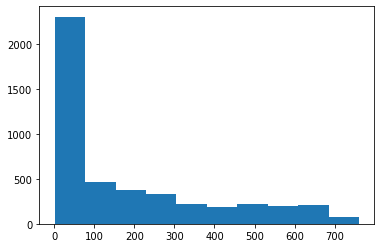

Total Seasons:  4573
Total Seasons >= 100 Events:  2113
Total Seasons >= 150 Events:  1825
Total Seasons >= 200 Events:  1570
Total Seasons >= 250 Events:  1307
Total Seasons >= 300 Events:  1117


In [24]:
# Let's determine the cutoff for events in a season that we want to use

plt.hist(frame2.events)
plt.show()

print('Total Seasons: ', len(frame2))
print('Total Seasons >= 100 Events: ', len(frame2[frame2.events >= 100]))
print('Total Seasons >= 150 Events: ', len(frame2[frame2.events >= 150]))
print('Total Seasons >= 200 Events: ', len(frame2[frame2.events >= 200]))
print('Total Seasons >= 250 Events: ', len(frame2[frame2.events >= 250]))
print('Total Seasons >= 300 Events: ', len(frame2[frame2.events >= 300]))

# Lets go with 200 as our cutoff

In [25]:
# Limit dataframe entries

df_yoy = frame2[frame2.events >= 200]

In [26]:
# First, let's get a baseline correlation for RBI

# We want a dataframe with the following columns

# batterID, year 1, rbi1, year 2, rbi2

# Possible commbos are 2017-18,2018-19,2019-20,2020-21

column_names = ['batter',
               'y1',
               'rbi1',
               'y2',
               'rbi2']

year_comp2 = pd.DataFrame(columns = column_names)

start_years = [2017,2018,2019,2020]

for i in df_yoy.batter.unique():
    # Make sure batter has 2+ years
    if len(df_yoy[df_yoy.batter == i].game_year.unique()) >= 2:
        # Do analysis with all excpe thte last year
        for j in df_yoy[df_yoy.batter == i].game_year.unique()[:-1]:
            y2_year = j + 1
            y1_val = df_yoy[(df_yoy.batter == i) & (df_yoy.game_year == j)].rbis_on_play.values[0]
            # Throwing an error for empty lists, will solve later
            y2_val = df_yoy[(df_yoy.batter == i) & (df_yoy.game_year == y2_year)].rbis_on_play.values
            year_comp2 = year_comp2.append({'batter': i,
                                        'y1': j,
                                        'rbi1': y1_val,
                                         'y2': y2_year,
                                         'rbi2': y2_val}, ignore_index = True)
            
year_comp2.head()

# We want to remove all empty lists

year_comp2 = year_comp2[year_comp2['rbi2'].map(lambda d: len(d)) > 0]

# Convert to floats
year_comp2.rbi2 = year_comp2.rbi2.apply(pd.Series)

# Let's get the correlation between the two columns

np.corrcoef(year_comp2.rbi1,year_comp2.rbi2)[1,0]

# 0.22, not too bad but not great

0.227502434763665

In [27]:
# Now, let's get the same measure for RBI above expectation

# We want a dataframe with the following columns

# batterID, year 1, rbi_pctoe_y1, year 2, rbi_pctoe_y2

# Possible commbos are 2017-18,2018-19,2019-20,2020-21

column_names = ['batter',
               'y1',
               'rbi_pctoe_y1',
               'y2',
               'rbi_pctoe_y2']

year_comp = pd.DataFrame(columns = column_names)

start_years = [2017,2018,2019,2020]

for i in df_yoy.batter.unique():
    # Make sure batter has 2+ years
    if len(df_yoy[df_yoy.batter == i].game_year.unique()) >= 2:
        # Do analysis with all excpe thte last year
        for j in df_yoy[df_yoy.batter == i].game_year.unique()[:-1]:
            y2_year = j + 1
            y1_val = df_yoy[(df_yoy.batter == i) & (df_yoy.game_year == j)].rbi_pctoe.values[0]
            # Throwing an error for empty lists, will solve later
            y2_val = df_yoy[(df_yoy.batter == i) & (df_yoy.game_year == y2_year)].rbi_pctoe.values
            year_comp = year_comp.append({'batter': i,
                                        'y1': j,
                                        'rbi_pctoe_y1': y1_val,
                                         'y2': y2_year,
                                         'rbi_pctoe_y2': y2_val}, ignore_index = True)
            
# We want to remove all empty lists

year_comp = year_comp[year_comp['rbi_pctoe_y2'].map(lambda d: len(d)) > 0]

# Convert to floats
year_comp.rbi_pctoe_y2 = year_comp.rbi_pctoe_y2.apply(pd.Series)

# View data
year_comp

,batter,y1,rbi_pctoe_y1,y2,rbi_pctoe_y2
0,134181.0,2017.0,0.352734,2018.0,0.059596
1,400121.0,2017.0,-0.164184,2018.0,-0.238797
2,405395.0,2017.0,0.181374,2018.0,0.059709
3,405395.0,2018.0,0.059709,2019.0,0.237880
5,408045.0,2017.0,0.063748,2018.0,-0.094494
...,...,...,...,...,...
952,669256.0,2020.0,-0.088566,2021.0,-0.190686
953,669257.0,2019.0,0.530448,2020.0,0.290209
954,669257.0,2020.0,0.290209,2021.0,0.076921
955,669374.0,2019.0,0.094748,2020.0,0.124439


In [28]:
# Let's get the correlation between the two columns

np.corrcoef(year_comp.rbi_pctoe_y1,year_comp.rbi_pctoe_y2)[1,0]

# 0.44, not great, but definitely better

0.4361459033481157

Text(0.5, 1.0, 'Year over Year RBI % Above Expectation')

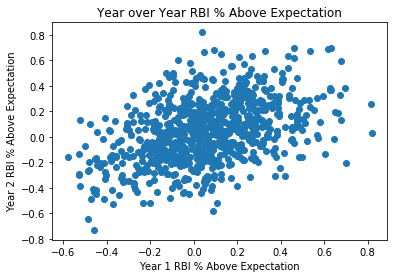

In [29]:
# Let's plot!

plt.plot(year_comp.rbi_pctoe_y1,year_comp.rbi_pctoe_y2,'o')
plt.xlabel('Year 1 RBI % Above Expectation')
plt.ylabel('Year 2 RBI % Above Expectation') 
plt.title('Year over Year RBI % Above Expectation')

# We can see a slight relationship, but it is certainly not a strong one
# This metric is a slight improvement but does not solve the issues of RBI